Easton Potokar

# Introduction

Neonatal seizures are a common occurrence and require immediate care. These seizures generally occur in a single location in the brain. Detection is only possible through continuous electroencephalogram (EEG) monitoring, but this is not possible in most NICUs (Newborn Intensive Care Units) due to the expertise needed to interpret EEGs that is generally not available. Alternative options include experts with remote access to the EEG. This still requires 24-hour surveillance, an expensive and heavy load. Another is a simplified easy-to-read trend of the EEG known as an amplitude integrated EEG (aEEG). While the aEEG has its strengths, drawbacks include the possibility of missing short duration and low amplitude seizures entirely. 

The dataset that will be used is available through a public repository containing EEG recordings of 79 term neonates (newborns) admitted to the NICU, with a median duration of 74 minutes available at https://zenodo.org/record/2547147. Each EEG recording includes 21 channels of data that correspond to a different location on the brain (see Fig. 1), and are recorded at 256Hz. These recordings were examined by three experts at second intervals and labeled a seizure or non-seizure. Also included is the neonates' clinical information, including body weight in grams, gestational age, and post menstrual age. 

\begin{center} 
\adjustimage{max size={0.3\linewidth}{0.3\paperheight}}{figs/eeg_channels.png}
%\caption{Fig 1. Locations of various EEG channels}
\end{center}
\hspace*{\fill}

Much research has been done on developing algorithms to identify seizures in adult patients, but little has been done to identify them in premature and full term infants.

Questions looking to be answered by this dataset include, but are not limited to: Is there a correlation between body weight and gestational age and frequency of seizures? Are they more prevalent in males or females? Are there certain frequencies in the EEG data where seizures occur? Do certain channels in the EEG recordings correlate more with seizures than others?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import mne                               #package to handle EEG data files
import os, seaborn, re, pywt
from scipy import io                     #for loading matlab file
from scipy import fftpack                #for Fourier Transform Analysis
%run Appendix.ipynb                      #reads data found in Appendix. Must be in
                                            #same directory
import warnings                          #disable some pandas plotting errors
warnings.filterwarnings("ignore", module="pandas") 
plt.style.use("seaborn")
plt.rcParams["figure.dpi"] = 300

fs = 256                                 #sample size

# Data Preparation
## Data Scraping

The data is publicly at [2], and is best downloaded using the python package `zenodo-get`. Running `pip install zenodo-get` followed by `zenodo_get.py 10.5281/zenodo.2547147` downloads all data and checks the md5sums to ensure proper download. Since this process was simple enough, no additional scraping methods were needed.

## Data Cleaning

### Cleaning Clinical Information

The data is stored in `.csv`, `.mat`, and `.edf` files. The `.edf` files are the standard for EEG data and can be read using the python package `mne`. From the `.csv` files we load the location of the corresponding EEG file,  ID of the infant (index from 1 to 79), gender, gestational age (GA) in weeks, post menstrual age (PMA) at time of EEG recording in weeks, and body weight (BW) in grams. GA refers to weeks from conception to birth and PMA is weeks from conception to current time. 

In addition, 22 of the neonates don't have any expert reviews, so we drop those rows, bringing the total to 57. We replace the strings in BW, GA, and PMA with floats at the center of their intervals. Since the intervals hold value with respect to each other (i.e., one interval is definitely larger than another), it is hoped this will aid in analysis. Further, any N/A features are replaced with the mean of other infants containing other similar features. The expert analysis is also loaded in from the `.mat` file and saved as a column in the pandas dataframe.

In [2]:
#load in clinical data
ci = pd.read_csv("data-og/clinical_information.csv", index_col="ID", usecols=["EEG file", "ID", "Gender", "GA (weeks)", "BW (g)", "EEG to PMA (weeks)", "Number of Reviewers Annotating Seizure"])

#drop rows without expert annotations
ci = ci[ ci["Number of Reviewers Annotating Seizure"] != 0]

#replace weight string values with middle of interval
replaceBW = {"less than 2500g": 2250,
              "2500 to 3000g": 2750,
              "3000 to 3500g": 3250,
              "3500 to 4000g": 3750,
              "greater than 4000g": 4250,
              }
ci.replace(replaceBW, inplace=True)

#replace GA/PMA string values with middle of interval
def interval(weeks):
    """Using Regex to find week number in string and converts to average"""
    if not isinstance(weeks, str) and np.isnan(weeks):
        return weeks
    values = re.compile(r"(\d{2})").findall(weeks)
    return (float(values[0]) + float(values[1])) / 2

ci["GA (weeks)"] = ci["GA (weeks)"].apply(interval)
ci["EEG to PMA (weeks)"] = ci["EEG to PMA (weeks)"].apply(interval)

#replace NaN values with something useful
#Both in the GA column
missing_idx = pd.isna(ci["GA (weeks)"])
for index, row in ci.loc[missing_idx].iterrows():
    similar = ci["EEG to PMA (weeks)"] == ci.loc[index, "EEG to PMA (weeks)"]
    ci.loc[index, "GA (weeks)"] = ci.loc[similar, "GA (weeks)"].mean()    
#and in the BW column
missing_idx = pd.isna(ci["BW (g)"])
for index, row in ci.loc[missing_idx].iterrows():
    similar = ci["GA (weeks)"] == ci.loc[index, "GA (weeks)"]
    ci.loc[index, "BW (g)"] = ci.loc[similar, "BW (g)"].mean() 
#there is a single missing m/f. Replace with the mode
missing_idx = pd.isna(ci["Gender"])
for index, row in ci.loc[missing_idx].iterrows():
    ci.loc[index, "Gender"] = ci["Gender"].mode()[0]

#load in all experts analysis from .mat file. Note we save as a numpy array b/c each child has a different length of recording
annot = io.loadmat("data-og/annotations_2017.mat")["annotat_new"]
ci["expertA"] = [annot[0,i-1][0,:] for i in ci.index]
ci["expertB"] = [annot[0,i-1][1,:] for i in ci.index]
ci["expertC"] = [annot[0,i-1][2,:] for i in ci.index]

#visualize a couple of rows and columns to see how it looks
ci.iloc[:,:5].sample(3)

,EEG file,Gender,BW (g),GA (weeks),EEG to PMA (weeks)
ID,,,,,
15,eeg15,m,2750.0,36.5,36.5
64,eeg64,f,2750.0,35.5,35.5
12,eeg12,m,2500.0,34.5,38.5


### Cleaning EEG Data

Next, we use `mne` to read all data into a pandas DataFrame. We upsample the expert analysis to save along with the EEG recordings. Further, we check that the experts' analyses length correctly lines up with the EEG length and we rename the EEG channels to match. 

In [ ]:
#iterate through all of files
for i in ci.index:
    #read in all of the raw data
    raw = mne.io.read_raw_edf("data-og/{}.edf".format(ci["EEG file"][i]))
    channels = raw.ch_names
    signals = raw[channels][0] * 10**6 #resize to micro volts
    time = raw[0,:][1]

    #clean channel names
    for k, chan in enumerate(channels):
        #if it contains -REF at end
        try:
            channels[k] = re.compile(r"\s(\w*?)-").findall(chan)[0]
        #otherwise take first word
        except:
            channels[k] = re.compile(r"\s(\w.*)").findall(chan)[0]
        #relabel to things I like better
        if channels[k] == "Effort":
            channels[k] = "Resp Effort"
        if channels[k] == "EKG":
            channels[k] = "ECG EKG"
    
    #check to make sure there"s no duplicate channels
    if len(set(channels)) != len(channels):
        raise ValueError("Channel has non unique data")
    #check to make sure has the same channels as the previous one
    if i == 1:
        chan_prev = channels
    else:
        if set(channels) != set(chan_prev):
            raise ValueError("EEGs have different channels")
        chan_prev = channels
    
    #save into pandas DataFrame
    df = pd.DataFrame(signals.T, columns=channels, index=time)
    
    #also upsample expert analysis with forward fill and save with it
    def upsample(low_res, high_res, name):
        """Upsamples low_res and saves as column with name into high_res"""
        low_res = pd.Series(low_res, np.arange(len(low_res)))
        temp = low_res.reindex(high_res.index, method="ffill")
        high_res[name] = temp
    upsample(ci.loc[i, "expertA"], df, "expertA")
    upsample(ci.loc[i, "expertB"], df, "expertB")
    upsample(ci.loc[i, "expertC"], df, "expertC")
    
    #check to make sure all experts analyzed correctly sized data
    if len(ci["expertA"][i]) != len(df.index) / 256:
        print(len(ci["expertA"][i]), len(df.index) / 256)
        raise ValueError(f"EEG {i} has mismatched expert A and time stamps")
    if len(ci["expertB"][i]) != len(df.index) / 256:
        print(len(ci["expertB"][i]), len(df.index) / 256)
        raise ValueError(f"EEG {i} has mismatched expert B and time stamps")
    if len(ci["expertC"][i]) != len(df.index) / 256:
        print(len(ci["expertC"][i]), len(df.index) / 256)
        raise ValueError(f"EEG {i} has mismatched expert C and time stamps")
        
    #save to pickle file and update location in ci
    print("Saving {} to pkl...".format(ci["EEG file"][i]))
    df.to_pickle("data-cleaned/{}.pkl".format(ci["EEG file"][i]), protocol=-1)
    ci.loc[i, "EEG file"] = "data-cleaned/{}.pkl".format(ci.loc[i, "EEG file"])
    
ci.to_pickle("data-cleaned/ci.pkl", protocol=-1)

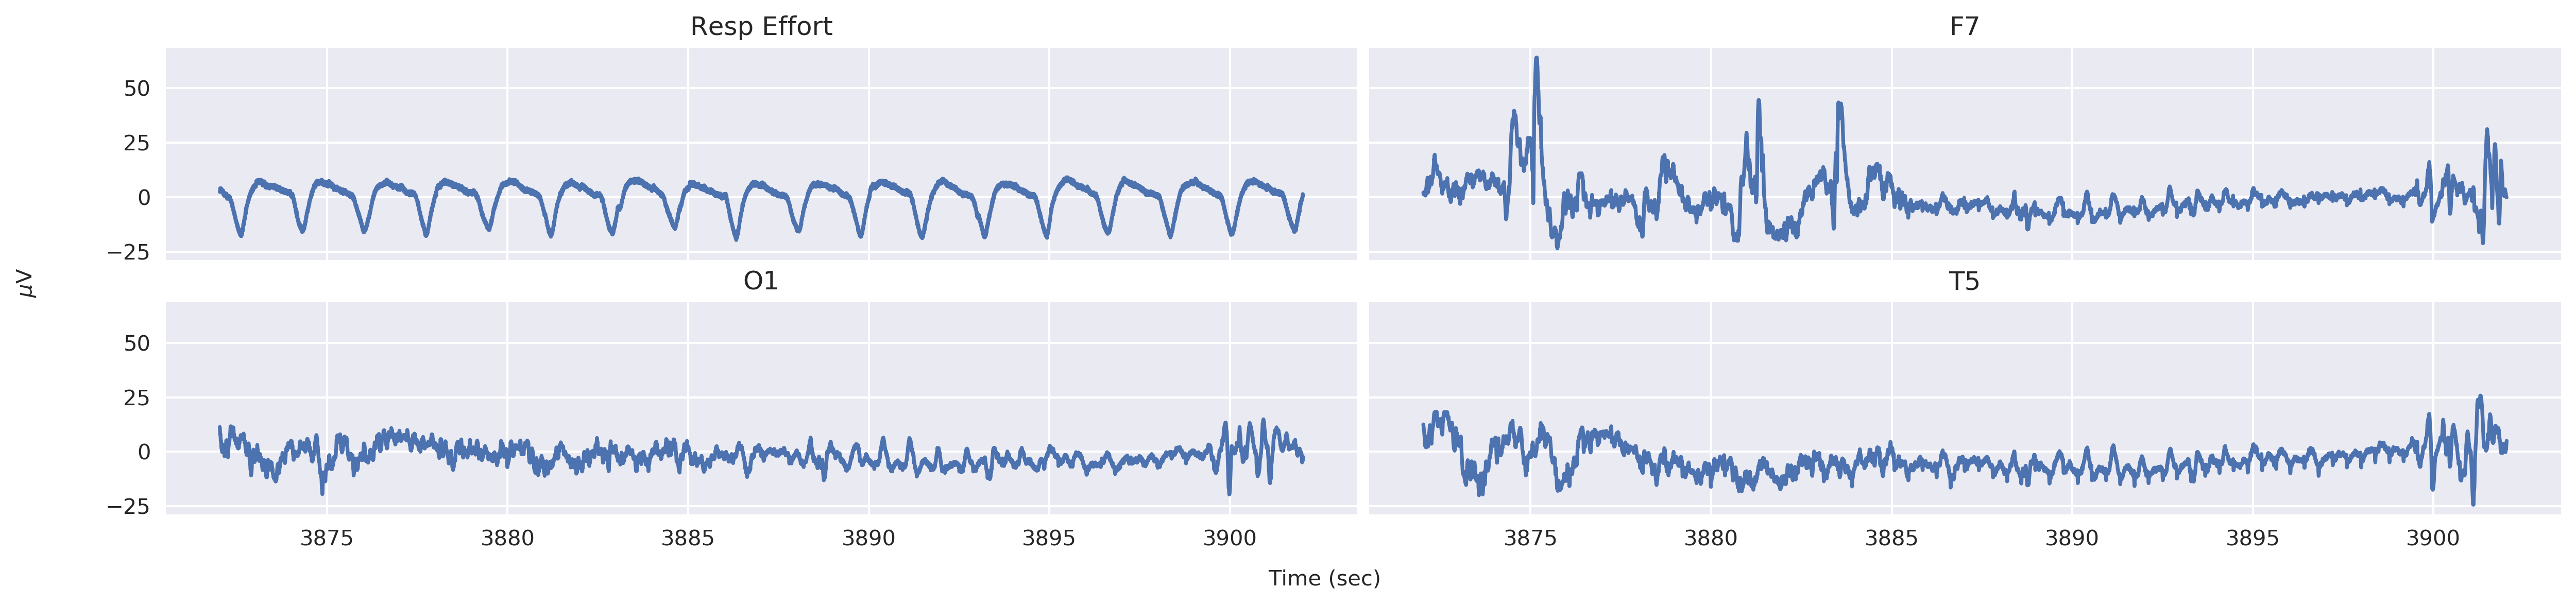

In [4]:
# we plot a random sample of 30 seconds from a random neonate
ci = read_data("data-cleaned/ci.pkl")
plot_signal(ci.loc[16, "EEG file"], channels=["Resp Effort", "F7", "O1", "T5"], slices=30)

## Potential Data Problems

I believe the data source to be quite reliable. The data was recorded by a third party in a Finnish hospital, which removes most bias or data picking. The group who posted it was looking to implement different ML algorithms to detect seizures and appear to have been moderately successful with an SVM. As long as the group didn't cherry-pick data for their model, which seems unlikely due to ethical reasons, the data should be sufficiently reliable.

Upon examining the data, I found that the length of recordings didn't match up with the length of some of the analyses by "Expert A" found in it's `.csv` file. Fortunately, a `.mat` file was also included in the dataset and all the recording lengths match up. Beyond that, all clinical data appears to have valid information. While examining some of the EEG recordings, it appears that some channels are occasionally mostly noise, which we'll examine in the frequency domain later.

# Feature Engineering

## Seizures

Here we split the EEG recordings into files of seizures and non-seizures. Note that we do this independently for each expert - thus giving us more data and accounting somewhat for discrepancy between them. If any experts have exactly the same seizure measured, then it will appear more than once, increasing the strength of that data point.

In [ ]:
for i in ci.index:
    #read in data
    df = read_data(ci.loc[i, "EEG file"]) 
    
    #not every expert reviewed each infant - make sure we get all data possible
    corr_experts = ci.loc[i, "Number of Reviewers Annotating Seizure"]
    num_experts = 0
    
    #function to split + save things
    def split(expert):
        """Takes in column name, and splits df using that column"""
        idx = df.iloc[:-1][expert].values - df.iloc[1:][expert].values
        idx = np.append(0, np.ma.nonzero(idx)[0]+1, len(df.index))
        for j in range(len(idx)-1):
            #get split we want
            temp = df.iloc[idx[j]:idx[j+1]].copy()
            #save metadata
            temp.ID = i
            temp.expert = expert[-1]
            temp.seizure = bool(temp[expert].iloc[0])
            temp._metadata = ["ID", "expert", "seizure"]
            #drop expert analysis since it"s not needed
            temp.drop(["expertA", "expertB", "expertC"], axis=1, inplace=True)
            #save
            temp.to_pickle(f"data-split/eeg{i}_{expert}_{j}.pkl", protocol=-1)
            
    #iterate through all experts if they analyzed it to save things
    if np.sum(ci.loc[i, "expertA"]) != 0:
        num_experts += 1
        split("expertA")
    if np.sum(ci.loc[i, "expertB"]) != 0:
        num_experts += 1
        split("expertB")
    if np.sum(ci.loc[i, "expertC"]) != 0:
        num_experts += 1
        split("expertC")
        
    #check to make sure we got them all
    if num_experts != corr_experts:
        raise ValueError(f"Should be {corr_experts}, only {num_experts} have annotated anything")
    print(i, end=" ")

## Clinical Information

We add features to the clinical data to analyze if any neonates were more at risk. We add percentage of time found in seizure, one hot encode the gender column, and add a recording length column.

In [6]:
ci = read_data("data-cleaned/ci.pkl")
#columns for length of recording
ci["seconds"] = [len(ci["expertA"][i]) for i in ci.index]

#make rows of expert averages
ci["expertA_avg"] = [np.sum(ci["expertA"][i]) / len(ci["expertA"][i]) for i in ci.index]
ci["expertB_avg"] = [np.sum(ci["expertB"][i]) / len(ci["expertB"][i]) for i in ci.index]
ci["expertC_avg"] = [np.sum(ci["expertC"][i]) / len(ci["expertC"][i]) for i in ci.index]

#make column of all expert averages
ci["expert_avg"] = (ci["expertA_avg"] + ci["expertB_avg"] + ci["expertC_avg"]) / (ci["Number of Reviewers Annotating Seizure"])

#create hot encoded gender column
ci["Male"] = ( ci["Gender"] == "m" ).apply(int)

ci.to_pickle("data-final/ci.pkl", protocol=-1)

## Discrete Fourier and Wavelet Transform 

To analyze the EEG channels, we need a way to compress them into smaller, more identifiable features. To this end, we investigate all channels both in the frequency domain and using wavelets. 

To calculate the frequency domain, we use the FFT. This will result in frequency up to 128Hz since it was recorded at 256Hz. 

For the wavelet transform, we utilize Daubechies wavelets of order 2 with four levels of decomposition, resulting in four details (D1, D2, D3, D4) and one approximation (A). This level of detail has been shown to capture the frequencies found in EEG recordings [1] well, and the smooth features of Daubechies wavelets of order 2 capture changes in the data particularly well. 

In [7]:
def fft(df):
    """FFT. Takes in DataFrame, and returns DataFrame with index of frequencies, and identical columns"""
    N = len(df.index)
    freq = fftpack.fftfreq(N, 1/fs)
    data = fftpack.fft(df, axis=0)
    idx = freq > 0
    return pd.DataFrame(np.abs(data[idx]), columns=df.columns, index=freq[idx])

def wavelet(df, wave="db2", level=4):
    """Wavelet Transform. Takes in DataFrame, and returns 5 DataFrames with and identical columns"""
    coeff = pywt.wavedec(df, wave, level=level, axis=0)
    return [pd.DataFrame(i, columns=data.columns) for i in coeff]

## Putting it all together
We extract the following features from the frequency and wavelet transforms:

Frequencies:  $\;\;$ 2-norm, entropy, mean, standard deviation, max frequency, value of max frequency  
A, D4, D3, D2, D1: 2-norm, entropy, mean, standard deviation, max value, min value

This results in $23*6*5$ features for wavelets and $23*6$ features for frequency, totaling 828 features. Using these features and the clinical information, we combine all the seizure/non-seizure data points into a pandas dataframe.

In [ ]:
rows_list = []
num = "0"
ci = read_data("data-final/ci.pkl")
for subdir, dirs, files in os.walk("data-split/"):
    for file in files:
        if file[-3:] == "pkl":
            #load data
            data = read_data("data-split/" + file)
            
            #get clinical features and misc features
            dic = ci.loc[data.ID, ["BW (g)", "GA (weeks)", "EEG to PMA (weeks)", "Male"]]
            dic["Seconds"] = data.index[-1] - data.index[0]
            dic["Seizure"] = data.seizure
    
            #get Fourier and Wavelet transform
            data_fft = fft(data)
            A, D4, D3, D2, D1 = wavelet(data)
            features = [data_fft, A, D4, D3, D2, D1]
            
            #iterate through them all adding the features we need
            names = ["Freq", "A", "D4", "D3", "D2", "D1"]
            for feature, name in zip(features, names):
                mean     = feature.add_prefix(f"{name}_Mean_").mean()
                stdev    = feature.add_prefix(f"{name}_Stdev_").std()
                norm     = feature.add_prefix(f"{name}_2norm_")
                norm     = np.square(norm).sum(axis=0) / norm.index.size
                entropy  = feature.add_prefix(f"{name}_Entropy_")
                mask     = entropy != 0
                entropy  = (np.square(entropy[mask])*np.log(np.square(entropy[mask]))).sum(axis=0) / entropy.index.size
                dic      = {**dic, **mean.to_dict(), **stdev.to_dict(), **norm.to_dict(), **entropy.to_dict()}
            
            #do the same for wavelet only features
            for feature, name in zip(features[1:], names[1:]):
                maximum     = feature.add_prefix(f"{name}_Max_").max()
                minimum     = feature.add_prefix(f"{name}_Min_").min()
                dic         = {**dic, **maximum.to_dict(), **minimum.to_dict()}
                
            #do the same for frequency only features
            for feature, name in zip(features[0:1], names[0:1]):
                maximum     = feature.add_prefix(f"{name}_Max_").max()
                idxmax      = feature.add_prefix(f"{name}_IdxMax_").idxmax()
                dic      = {**dic, **maximum.to_dict(), **idxmax.to_dict()}
                
            rows_list.append( dic )
            
            if num != file[3:5]:
                num = file[3:5]
                print(num, end=" ")
            
df = pd.DataFrame(rows_list)
df.to_pickle("data-final/eeg.pkl", protocol=-1)

# Data Visualization

We compare clinical information to see if any physical properties of neonates make him/her more likely to have a high percentage of time spent in seizures.

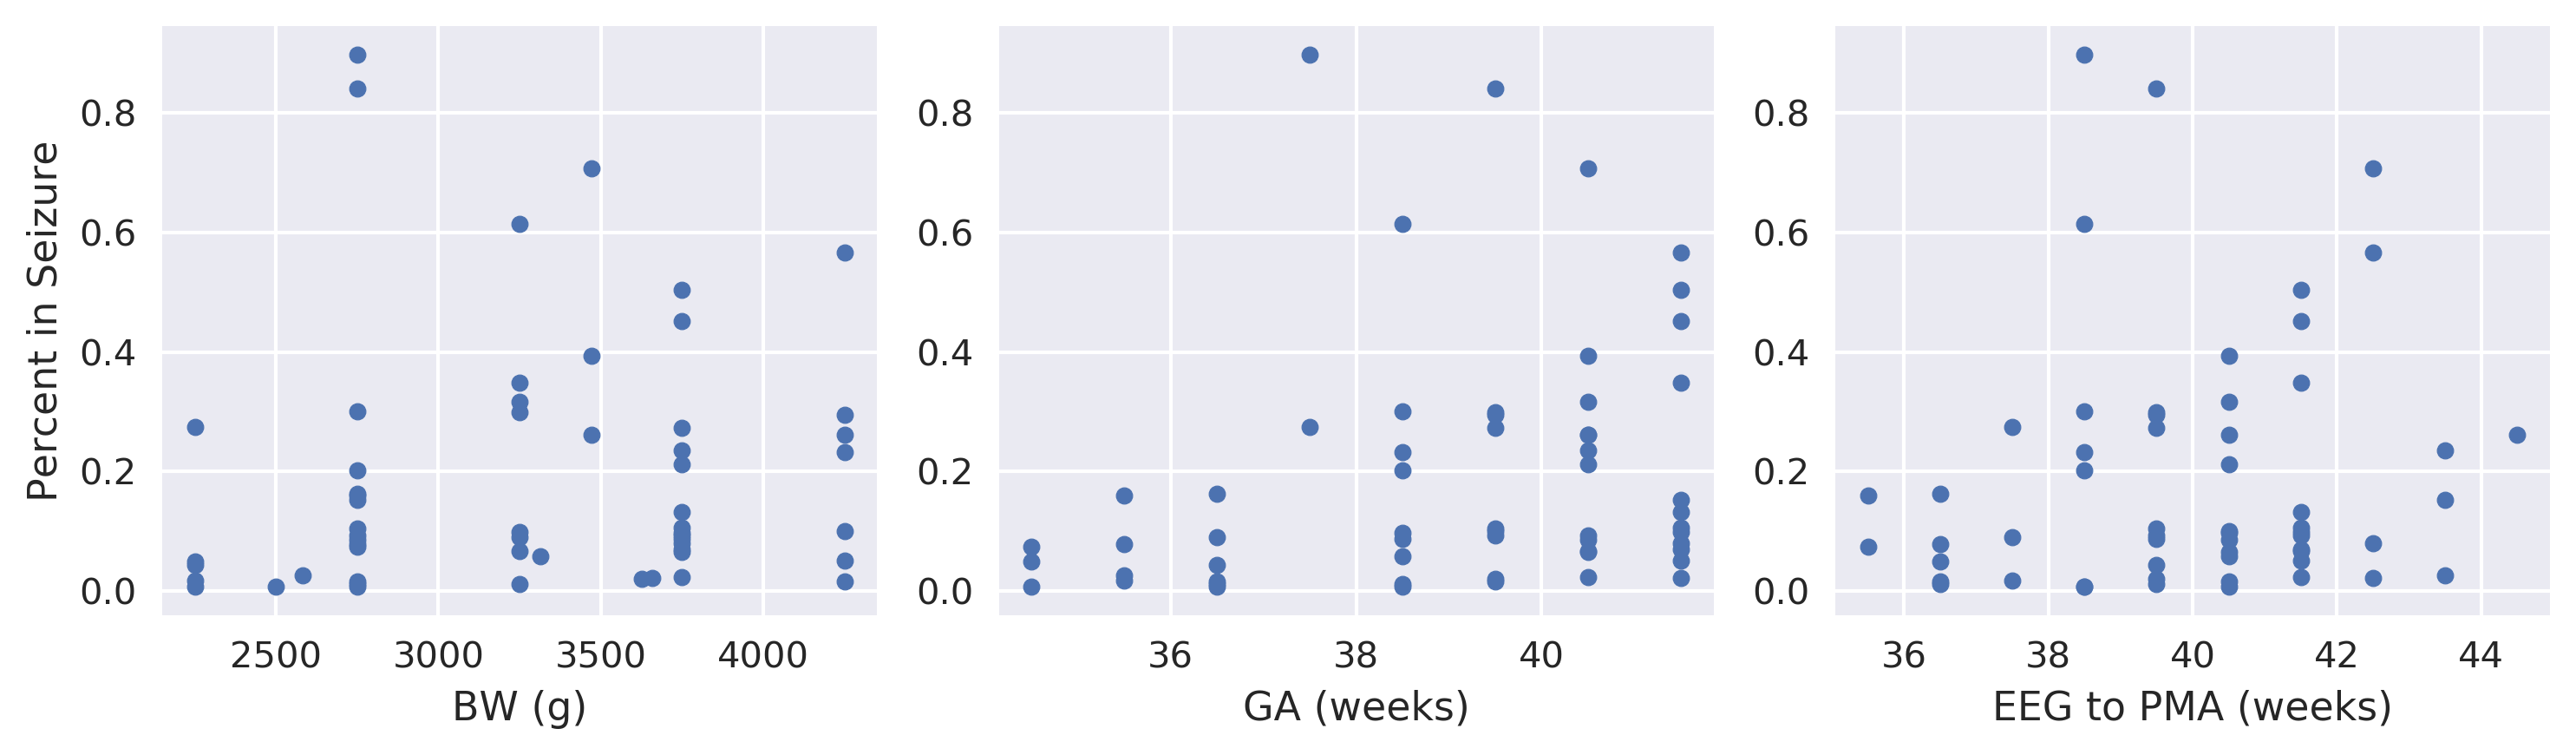

In [19]:
#read in all data
ci = read_data("data-final/ci.pkl")
df = read_data("data-final/eeg.pkl")

cols = ["BW (g)", "GA (weeks)", "EEG to PMA (weeks)"]
fig, ax_new = plt.subplots(1,3, sharey=False, figsize=(10,3))
titles = ["Percent in Seizure", "", ""]
for ax, col, title in zip(ax_new, cols, titles):
    ci.plot(kind="scatter", x=col, y="expert_avg", ax=ax, legend=None)
    ax.set_ylabel(title)
plt.tight_layout()

Notice this shows that there is a decent correlation between GA and PMA and the percent of seizures. Being older doesn't necessarily mean the neonate will definitely have seizures, but may make it possible to have more frequent seizures due to a more developed brain. We are decently undersampled here, so it could just be due to random variation.

Similarly, we analyze seizure percentage and see if gender has a role to play.

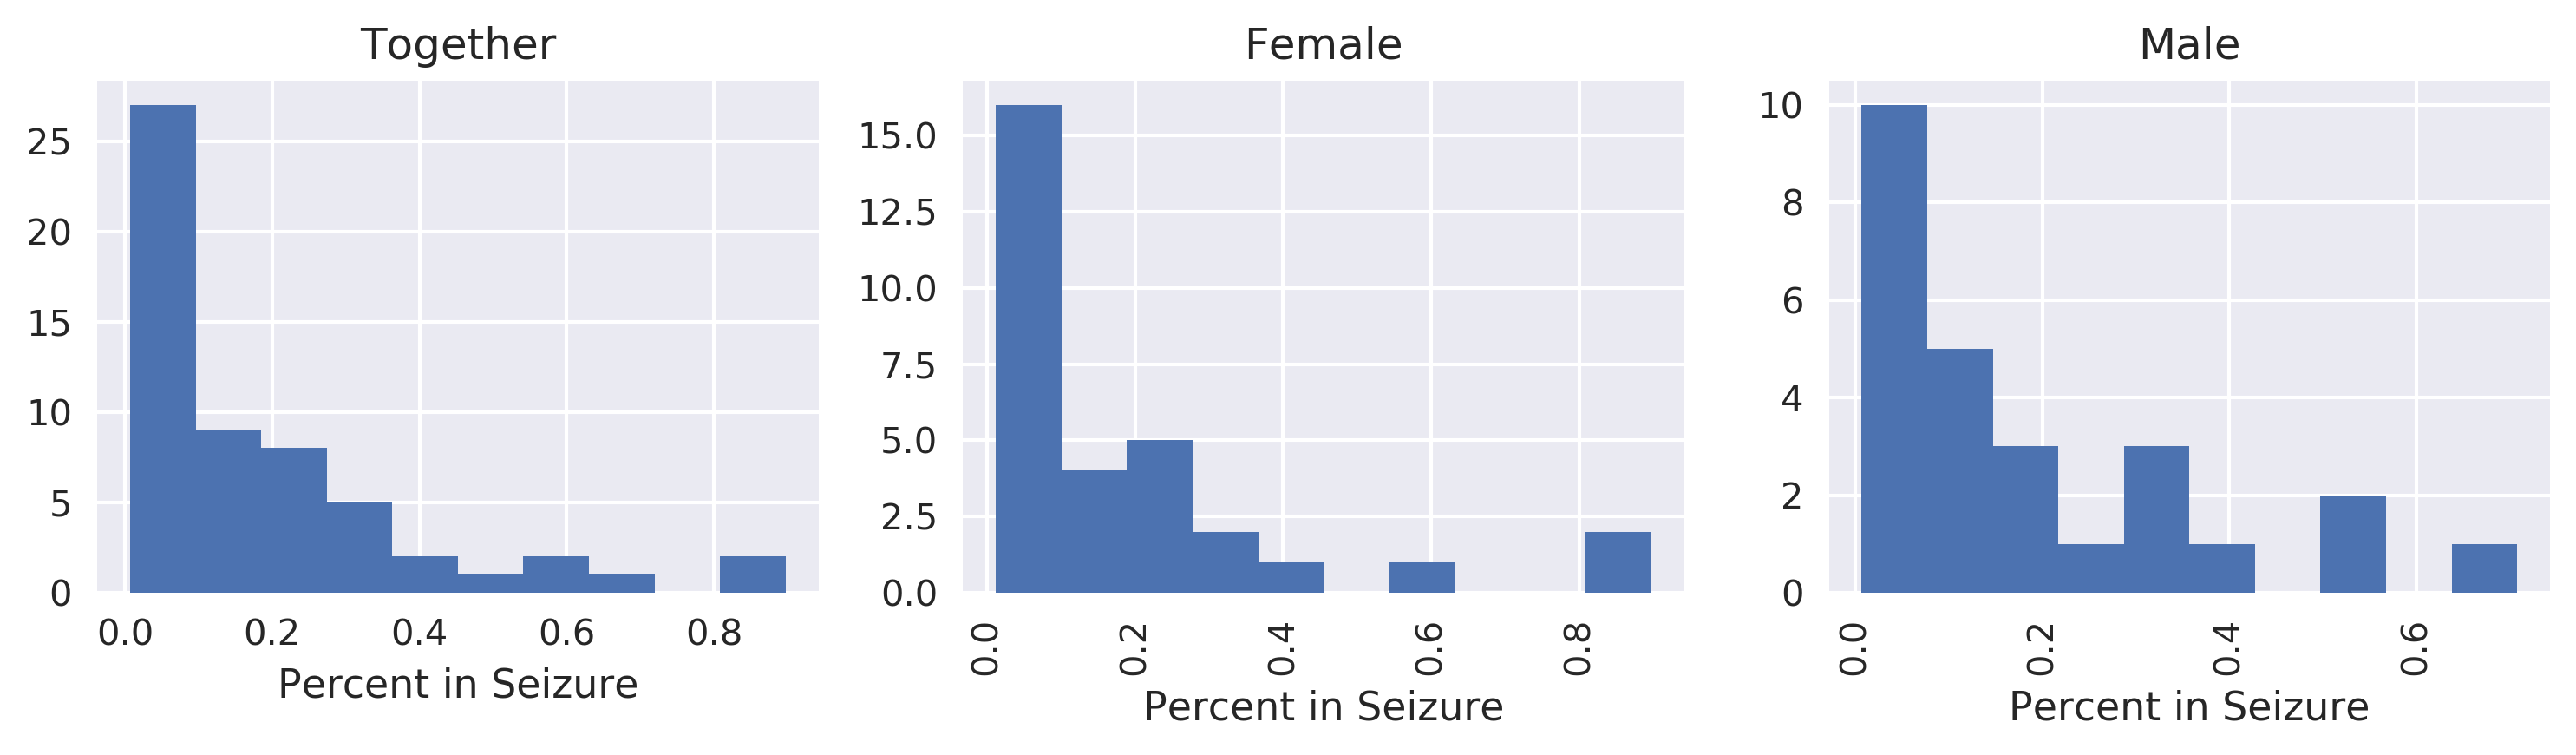

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ci[["expert_avg"]].hist(ax=ax[[0]])
ci[["Gender", "expert_avg"]].hist(by="Gender", ax=ax[[1,2]])
titles = ["Together", "Female", "Male"]
for i, title in enumerate(titles):
    ax[i].set_title(title)
    ax[i].set_xlabel("Percent in Seizure")
plt.suptitle("")
plt.tight_layout()
plt.show()

It appears it does not. The distributions seem to be very similar. However, it can be noted that most neonates have very few seizures.

Next, we plot some EEG features we extracted to see if any correlations exist. We randomly select the T5 channels with the A, D1, and frequency features. Note that all channels and features were plotted and appear to have similar properties, so to save space we only include these.

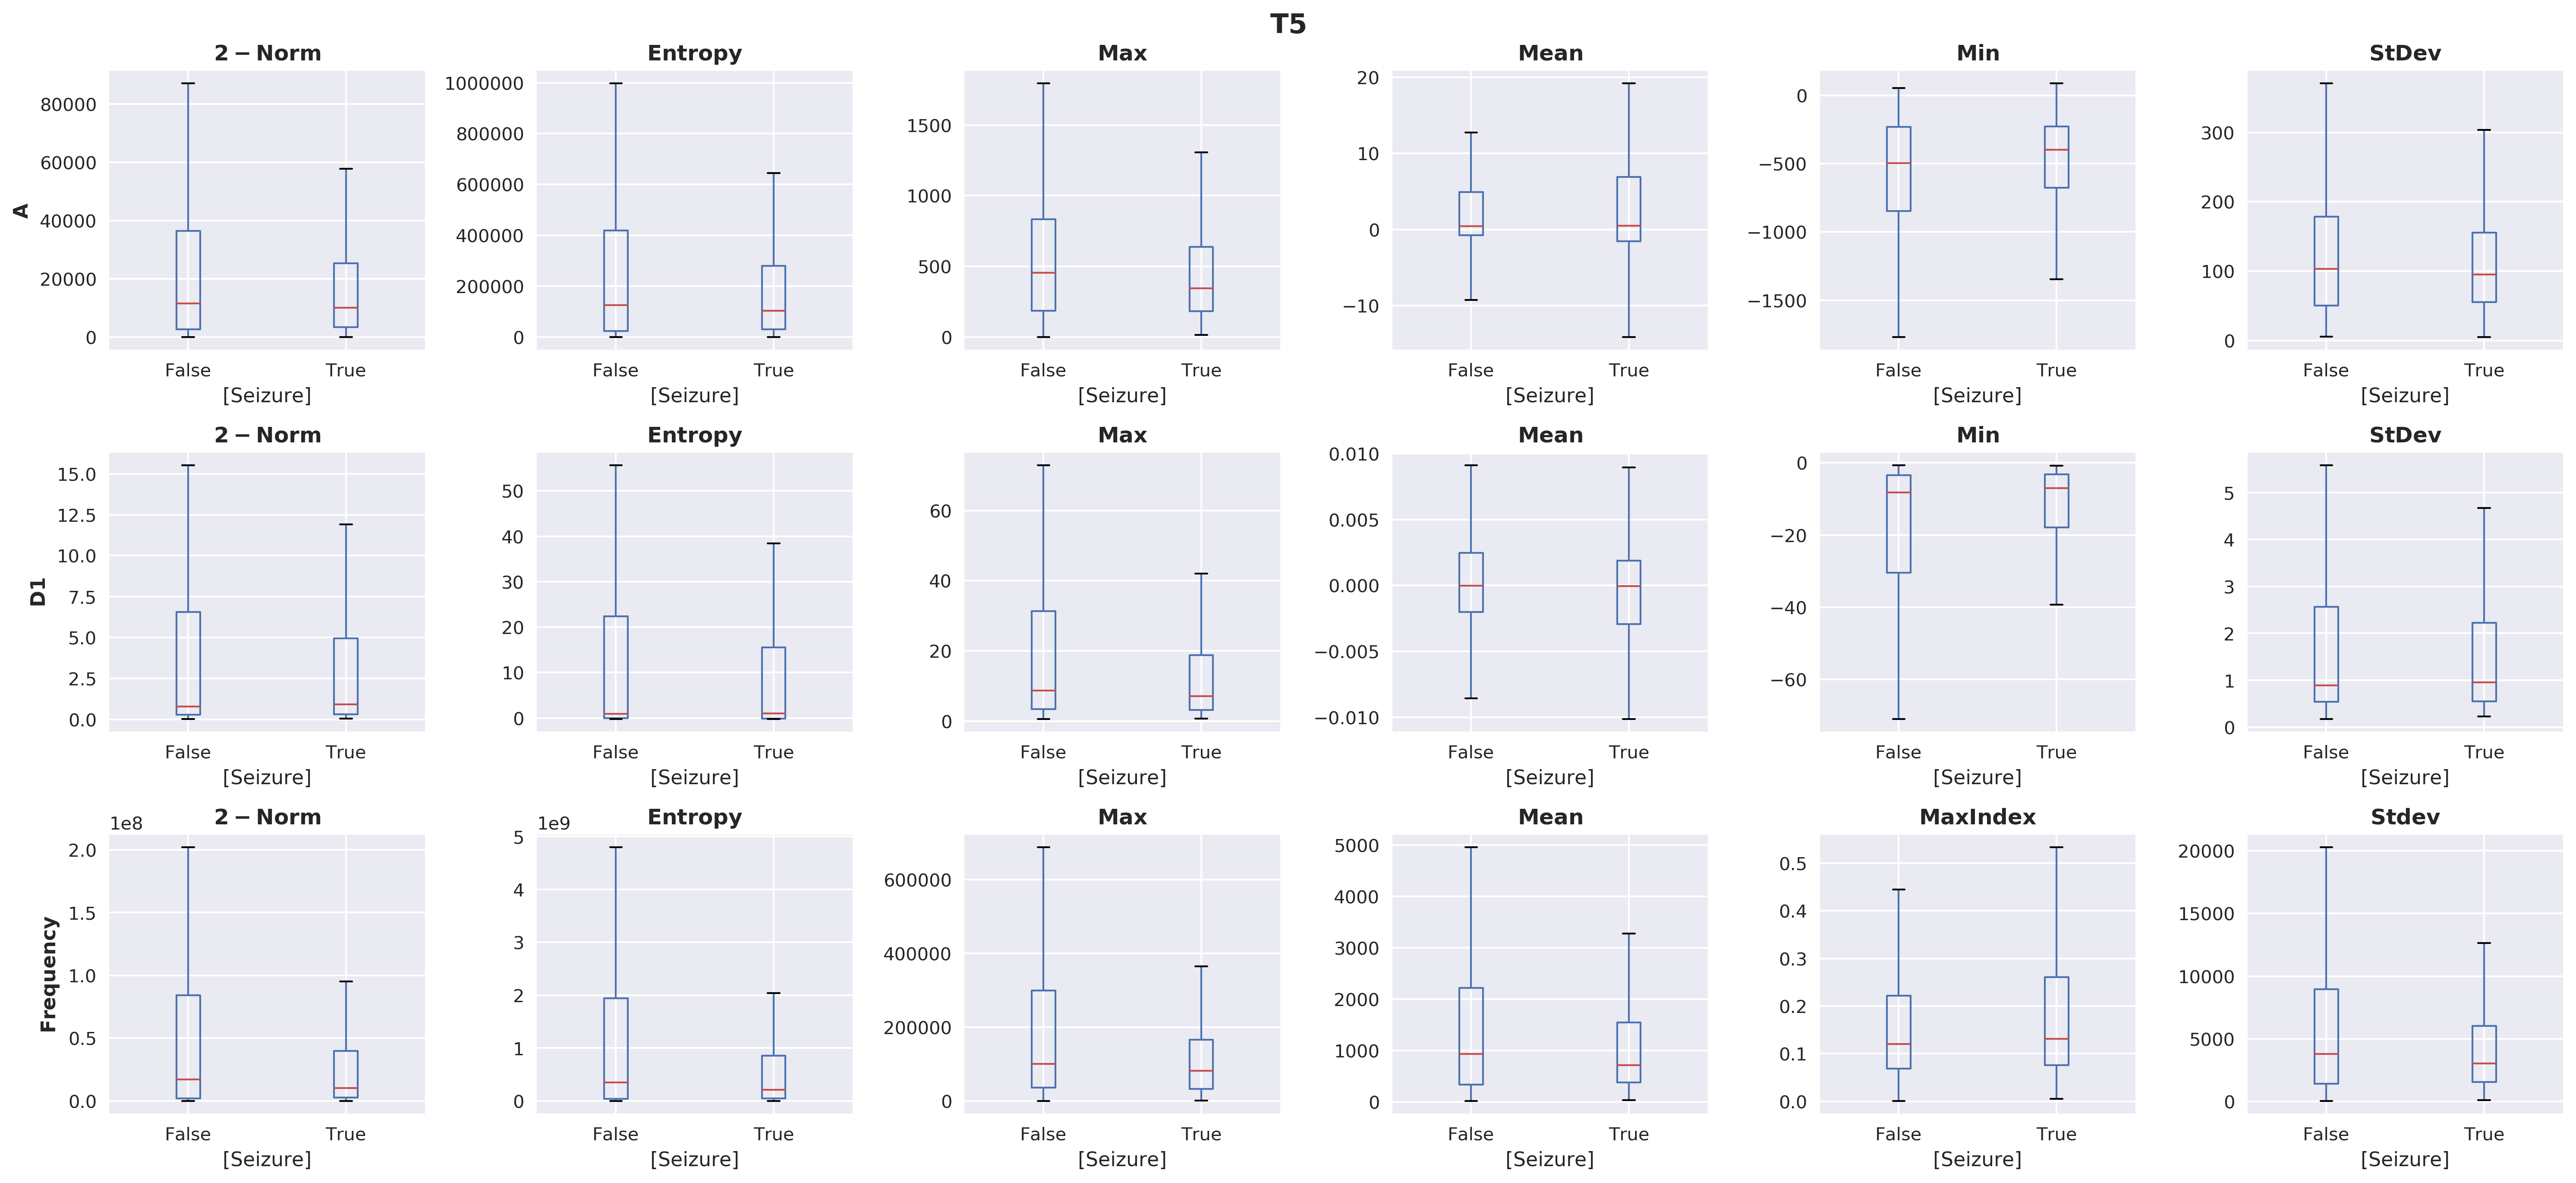

In [4]:
T5_cols = [col for col in df if (col.endswith("T5") and col.startswith(("A", "Freq", "D1"))) or col == "Seizure"]
plot_features(T5_cols, df, "T5")

The frequency, A, D1, and D2 features seem to have the starkest contrast. This may imply that such a deep wavelet transform isn't necessary. Further, the differences in the frequency domain seem to imply that there is significantly less variance in frequency strength when seizures are occurring, as noted by the lessened 2-norm, Max, Min, and Stdev. This may imply that the lower frequency content that occurs in non-seizures is lessened during seizures while higher frequencies are more common. Very similar trends can be seen in A, D1, and D2 features as well, likely due to similar causes. 

We analyze the respiratory effort in an identical manner.

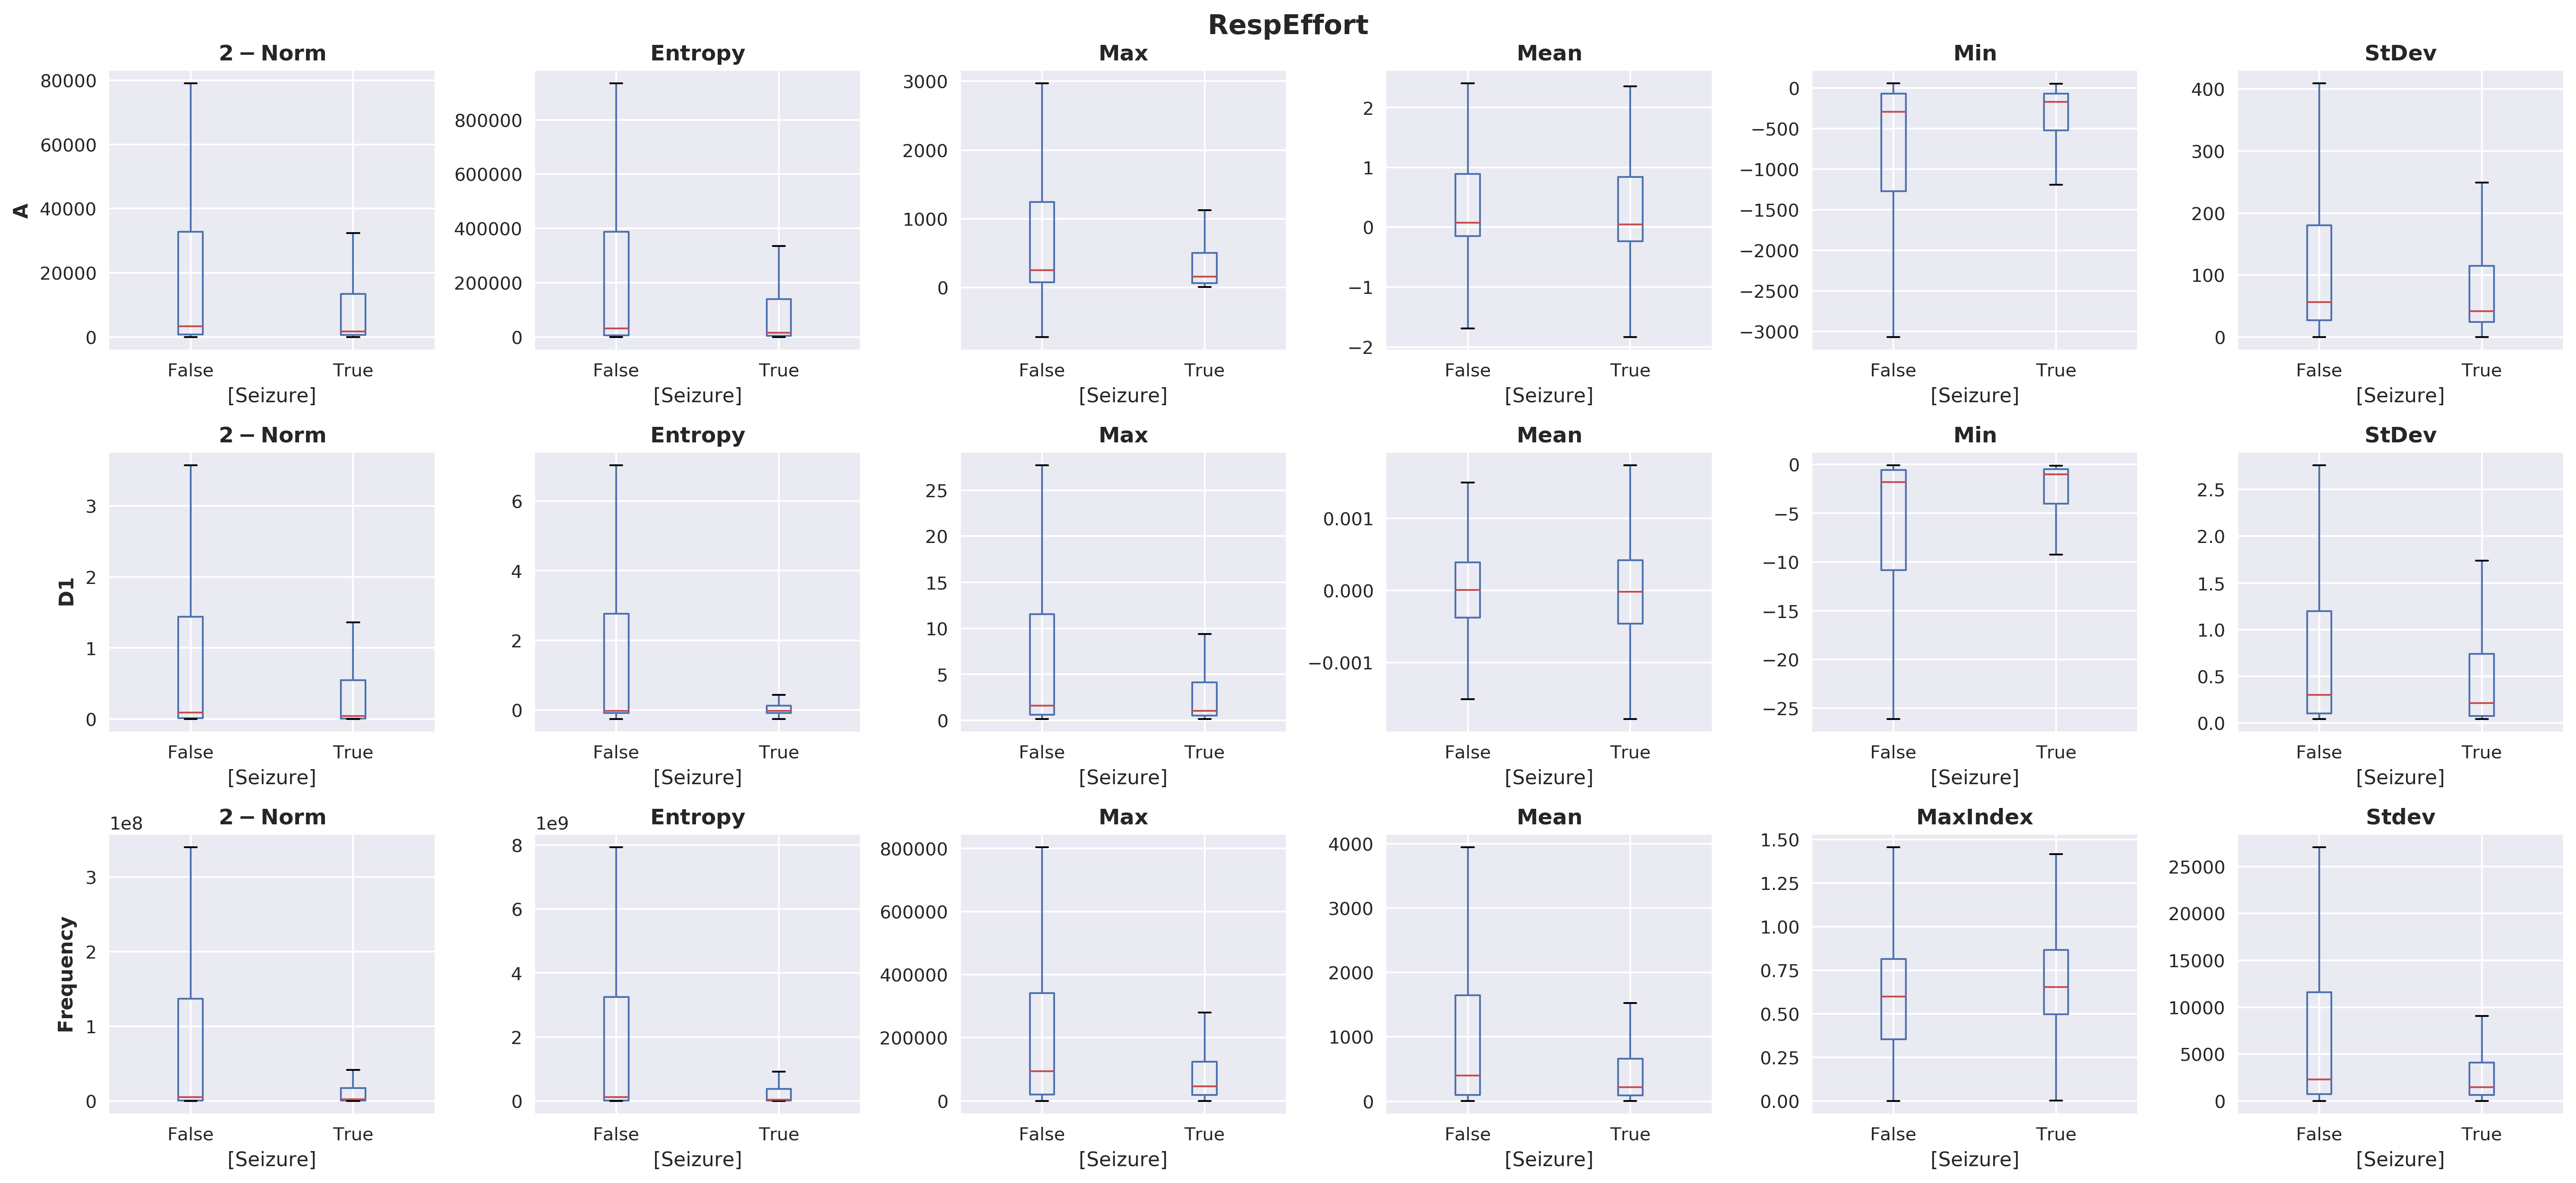

In [5]:
Resp_cols = [col for col in df if (col.endswith("Resp Effort") and col.startswith(("A", "Freq", "D1"))) or col == "Seizure"]
plot_features(Resp_cols, df, "Resp Effort")

This is super interesting. It appears that while having a seizure the infant's breathing becomes more shallow - implied by the much smaller minimums, maximums, 2-norms, and entropies across all transform features, and much lower mean frequency. This doesn't necessarily mean that the same frequencies aren't present, just that they don"t have anywhere near the same amplitude. In fact, notice the largest frequency still appears to be nearly the same, it just has a much lower amplitude.

We also analyze the correlation matrices of the T5 channel. Note we don't care much about the correlation between each wavelet decomposition and frequencies, so we analyze them separately.

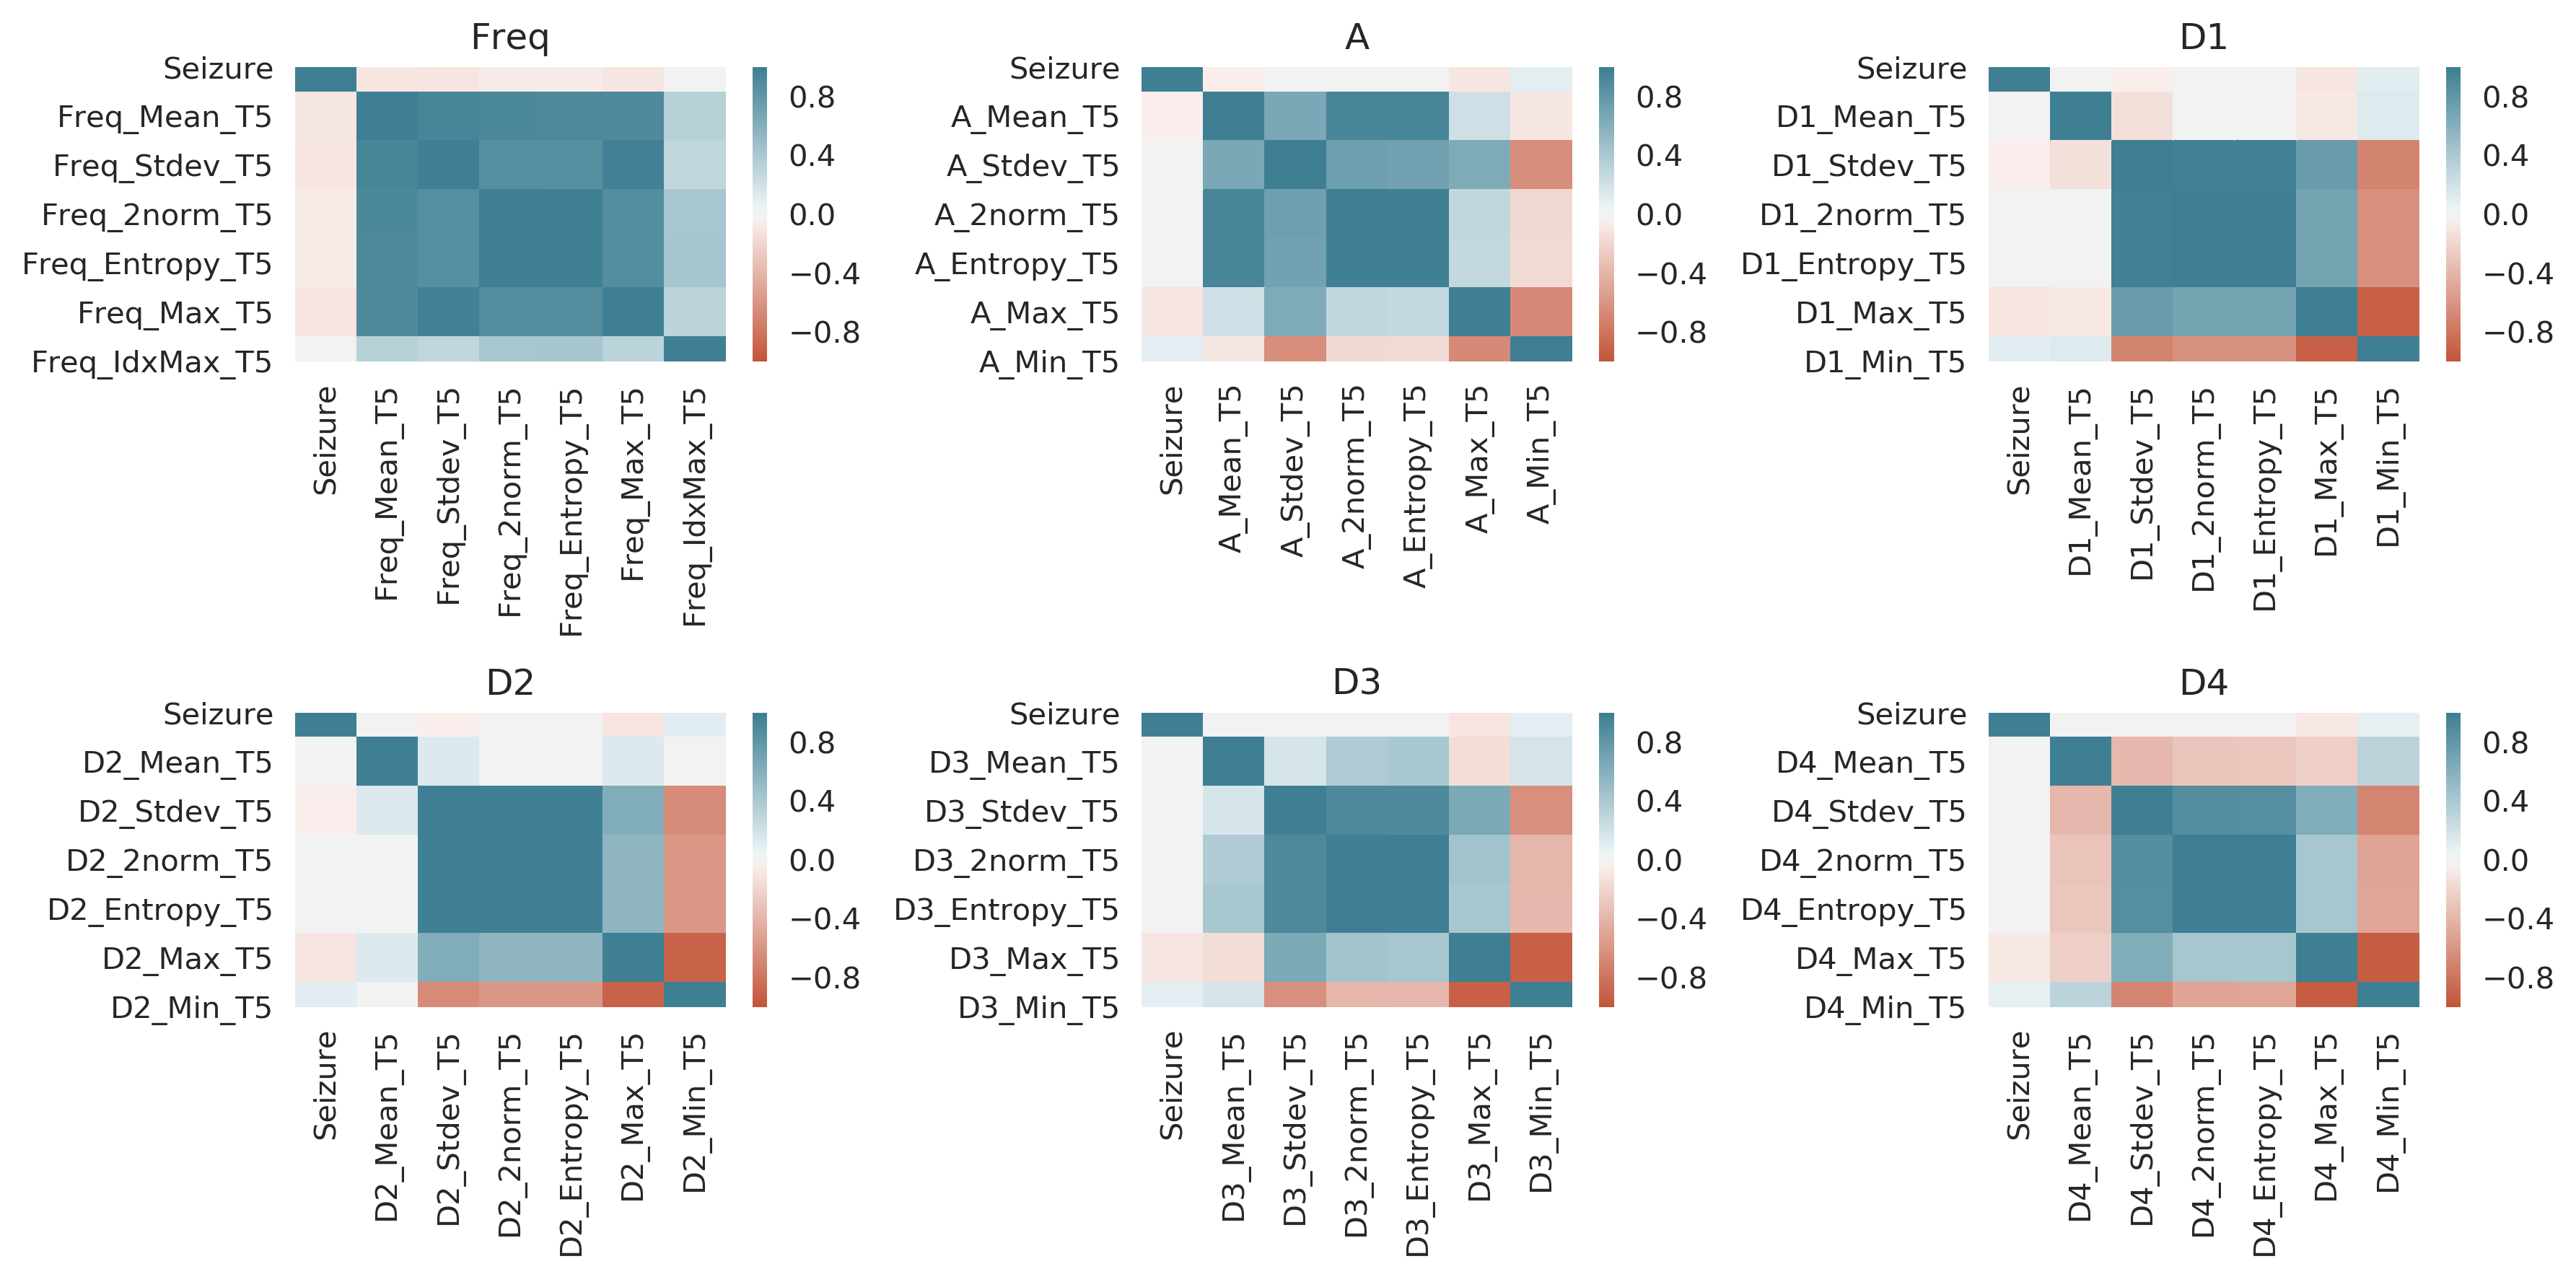

In [5]:
fig,ax = plt.subplots(2, 3, figsize=(12,6))
ax = ax.reshape(-1)
for i, name in enumerate(["Freq", "A", "D1", "D2", "D3", "D4"]):
    T5 = [col for col in df if (col.endswith("T5") and col.startswith((name))) or col == "Seizure"]
    corr = df[T5].corr()
    seaborn.heatmap(corr, vmin=-1, vmax=1, cmap=seaborn.diverging_palette(20, 220, n=200), ax=ax[i])
    ax[i].set_title(name)
plt.tight_layout()
plt.show()

Unfortunately, this seems to imply that there's not much correlations between the seizures and the features we've extracted. This is likely due to the fact that seizures occur in only a single part of the brain. This means that many of the seizures' intervals have non-seizure like channels that are aggregated with all the seizure channels and skew the data. Ideally, we'd need data that specifies exactly what channels the seizures were present in. This is why basic stats likely can't capture the nuances of the realationship, where a deep learning model may.

# Conclusion

Even with relatively clean data coming in, there was significant work to do to clean both clinical information and to transform the EEG recordings into something useful. Once this was done, there were trends from which we can draw conclusions.

First, it appears that the neonate's brain must be developed enough to encounter frequent seizures, shown by many of the older neonates (both in GA and PMA) having a lot higher percentage of seizures than not.

When seizures are occurring, it appears the low frequencies that are present in non-seizure time periods are greatly reduced, resulting in a much smaller 2-norm and entropy. In literature about seizures and EEG recordings of adults, this is very common - it's believed that seizures are represented by high frequencies and lack of low frequencies, which is what we're seeing.

Further, the starkest contrast between seizure and non-seizure time periods is in respiratory effort. The frequencies' amplitudes reduce significantly when a seizure is occurring and can be seen in both the Fourier and the Wavelet Transform. This is likely due to the shallower breathing of the neonates as they are struggling through the seizure. 

There appears to be little correlation between our features and a seizure occurring. This is because it is difficult to analyze channels because seizures will happen in only one area of the brain. This means the neonate may be having a seizure in one part of the brain while another part of the brain looks normal. Thus the non-seizure reading gets clumped with the seizure reading, skewing the data.

The data does suggest that there's enough differentiating features that a machine learning model such as a logistic regression, neural network, etc. could likely accurately predict whether a seizure is occurring.

# References

[1] Nabeel Ahammad, Thasneem Fathima, and Paul Joseph, “Detection of Epileptic Seizure Event and Onset Using EEG,” BioMed Research International, vol. 2014, Article ID 450573, 7 pages, 2014.

[2] Nathan Stevenson, Karoliina Tapani, Leena Lauronen, & Sampsa Vanhatalo. (2018). A dataset of neonatal EEG recordings with seizures annotations [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1280684